Importing all the necessary libraries

In [1]:
import tensorflow as tf

In [2]:
import glob
#The glob module is used to find file paths matching a specified pattern. In image processing, it's often used to load all images from a directory based on a specific file extension, like .jpg or .png.
import imageio
#imageio is a library that allows reading and writing images. You can use it to read image files and manipulate or process them in your machine learning model.
import matplotlib.pyplot as plt
import numpy as np
import os
#The os module provides functions to interact with the operating system, like navigating through file directories, creating folders, or checking paths. This is useful for handling datasets stored in the local system.
import PIL
#PIL (often accessed via Pillow, its more modern form) is used for image manipulation. It allows you to open, resize, and convert images, among other operations. This is particularly useful for preprocessing images before feeding them into a neural network.
from tensorflow.keras import layers
import time

from IPython import display
#This module is used to display rich media (like images, videos, etc.) directly in a Jupyter notebook. In machine learning workflows, this is often used to dynamically show output (like progress or images) during model training or evaluation.

Import and preprocess dataset


In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')#common pratice in image processing
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000#no should be greater than equal to length of dataset for shuffling
BATCH_SIZE = 256# at a time 256 images are trained

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#changes input into a format so model can apply transformations easily to input

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))#takes 100 points from a random normal distribution
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))#reshape the output of first to 7*7 rows and 256 columns
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())#image size increases through each layer.here we are upsampling 
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)#assert is just to check whether the shape at each layer is what we actually desired.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))# tanh because output between -1 to 1
    assert model.output_shape == (None, 28, 28, 1)#original image shape

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


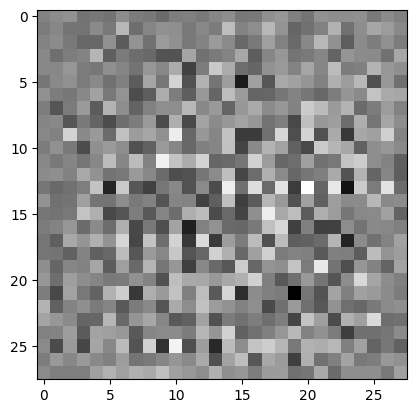

In [8]:
generator = make_generator_model()# create an instance

noise = tf.random.normal([1, 100])#random noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#its not learned yet just checking
#no of parameters are more for generator than discriminator

In [9]:
def make_discriminator_model():#simple two cnn layer nn
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))#same size as generator output
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00050835]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)#binary classification

In [12]:
def discriminator_loss(real_output, fake_output):#custom loss function
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)#real images desired output is a matrix of all 1s
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)#generated images desired output is a matrix of all zeros
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)#desired output is a matrix of all ones

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# while training the models will be saved in the particular directory optional just to keep track of the training process

In [17]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16#16 sample of noises

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])#during testing time
#replicates the same random noise while testing

Creating custom training loop

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])#creates noise and go into generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:#tracking gradients that is loss function as time changes
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)#input to generator
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#finding gradient and optimizing
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

complete traning loop

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()#record time

    for image_batch in dataset:
      train_step(image_batch)#provide batches of data from dataset

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')#because output we have is in -1 to 1
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

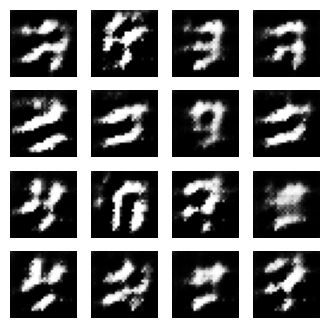

Time for epoch 4 is 659.3441896438599 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))